## Setup / Log-in ⚙️

Connect to google drive, navigate to documentation markdown, and download Mistral model

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import notebook_login
from IPython.display import clear_output
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import json
import re

# Mount drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive'

# Download Mistral
hf_access_token = "" # TOOD: Replace with your token
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1", token=hf_access_token).to("cuda")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1", token=hf_access_token)
clear_output()

## Split Documentation into Pieces 🧩

Specifiy the documentation's file path, a tag to split the document into sections on, and a blurb indicating a high-level summary of the company.

In [ ]:
file_path = 'Actian.md'
split_on = "###"
company_blurb = "Actian is an American software company that provides analytics-related software, products, and services. The company sells database software and technology, cloud engineered systems, and data integration solutions."

Created 16 sections from Actian.md
Shortest section: 38 tokens
Longest section: 808 tokens


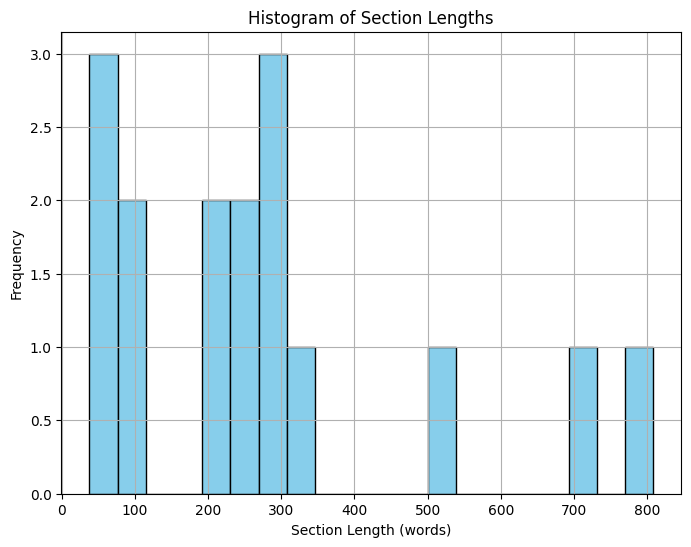

In [ ]:
# Read the documentation
def read_markdown_file(file_path):
  try:
      with open(file_path, 'r', encoding='utf-8') as file: markdown_content = file.read()
      return markdown_content
  except FileNotFoundError: return f"File '{file_path}' not found."
  except Exception as e: return f"An error occurred: {e}"
doc_txt = read_markdown_file(file_path)

# Split the documentation into sections based on the `split_on` tag
splits = doc_txt.split(split_on)
splits = [split_on+section for section in splits if section.strip()]
split_sizes = [len(tokenizer(split)['input_ids']) for split in splits]
print("Created",len(splits),"sections from",file_path)
print("Shortest section:",min(split_sizes),"tokens")
print("Longest section:",max(split_sizes),"tokens")

# Plot histogram of section lenghts
plt.figure(figsize=(8, 6))
plt.hist(split_sizes, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Section Length (words)')
plt.ylabel('Frequency')
plt.title('Histogram of Section Lengths')
plt.grid(True)
plt.show()


## Automatically Generate Q/A for each Section

### Option 1 - Manual Questions 🤔

In [ ]:
format_str = "Format your response ONLY as a single json of question and answer pairs like this [{\"question\":\"...\", \"answer\":\"...\"},{\"question\":\"...\", \"answer\":\"...\"}]."
training_data = []
for section in splits:
    print("SECTION\n------------------")
    print(section[0:100] + "...\n")

    prompt1 = "{} Pretend you are a professor creating a comprehensive quiz to test your student's understanding of Actian's documentation. Create an exahustive suite of questions and answer pairs based on the following section of documetnation:\n{}\n{}".format(company_blurb, section, format_str)
    prompt2 = "{} You are a large language model tasked with generating fine-tuning data from source documentation. Create an exahustive suite of questions and answer pairs based on the following section of documetnation:\n{}\n{}".format(company_blurb, section, format_str)
    prompt3 = "{} Create an exahustive suite of questions and answer pairs that cover the main, broad topics covered in the following section of documetnation:\n{}\n{}".format(company_blurb, section, format_str)
    prompt4 = "{} Create an exahustive suite of questions and answer pairs that cover all small, technical details covered in the following section of documetnation:\n{}\n{}".format(company_blurb, section, format_str)

    for prompt in [prompt1, prompt2, prompt3, prompt4]:
        print("PROMPT\n------------------")
        print(prompt[0:1500]+"\n")

        messages = [{"role": "user", "content": prompt}]
        encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
        model_inputs = encodeds.to("cuda")

        generated_ids = model.generate(model_inputs, max_new_tokens=10000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
        decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        for item in decoded:
            json_str = item.split("[/INST]")[-1]
            json_str = json_str[0:json_str.rfind('}')+1]+']' # Fix Q/As that got cut off by new-token limit
            pattern = r'"question"\s*:\s*"(.*?)",\s*"answer"\s*:\s*"([^"]*?)"'
            matches = re.findall(pattern, json_str)
            question_answer_pairs = [(match[0], match[1]) for match in matches]
            print("OUTPUT\n------------------")
            for question, answer in question_answer_pairs:
                print("Question:", question)
                print("Answer:", answer.strip())  # Strips leading/trailing whitespace
                training_data.append({"prompt": question, "completion": answer})
            print("\n")

    # Save the training data into a csv file
    pd.DataFrame(training_data).to_csv('train.csv', index=False)

SECTION
------------------
#### .NET Data Provider Classes
The .NET Data Provider is the runtime component that provides the in...

PROMPT
------------------
Actian is an American software company that provides analytics-related software, products, and services. The company sells database software and technology, cloud engineered systems, and data integration solutions. Pretend you are a professor creating a comprehensive quiz to test your student's understanding of Actian's documentation. Create an exahustive suite of questions and answer pairs based on the following section of documetnation:
#### .NET Data Provider Classes
The .NET Data Provider is the runtime component that provides the interface between the .NET application and Actian databases.

The .NET Data Provider namespace (Ingres.Client) and its contents follow the same pattern as the Microsoft data providers.

All public static members are safe for multithreaded operations. To reduce unnecessary overhead, instance members a

### Option 2 - Question Suite

In [ ]:
# Load question suite
file_path = 'questionSuite.json'
with open(file_path, 'r',encoding='utf-8') as file:
    message_pairs = json.load(file)

In [ ]:
EOS_TOKEN = tokenizer.eos_token
training_data = []
for section in splits:
    print("SECTION\n------------------")
    print(section[0:100] + "...\n")
    doc_txt = """{} Here is a section from the company's documentation:\n{}""".format(company_blurb, section)

    for messages in message_pairs:

        # Encode the messages
        try: messages[-1]["content"] = messages[-1]["content"].format(doc_chunk=doc_txt)
        except: pass
        print("PROMPT\n------------------")
        print(messages[-1]["content"][0:1500]+"\n")
        encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
        model_inputs = encodeds.to("cuda")

        # Generate the answers
        generated_ids = model.generate(model_inputs, max_new_tokens=10000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
        decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        for item in decoded:
            json_str = item.split("[/INST]")[-1]
            json_str = json_str[0:json_str.rfind('}')+1]+']' # Fix Q/As that got cut off by new-token limit
            pattern = r'"question"\s*:\s*"(.*?)",\s*"answer"\s*:\s*"([^"]*?)"'
            matches = re.findall(pattern, json_str)
            question_answer_pairs = [(match[0], match[1]) for match in matches]
            print("OUTPUT\n------------------")
            for question, answer in question_answer_pairs:
                print("Question:", question)
                print("Answer:", answer.strip())  # Strips leading/trailing whitespace
                training_data.append({"prompt": question, "completion": answer})
            print("\n")

    # Save the training data into a csv file
    pd.DataFrame(training_data).to_csv('train.csv', index=False)